In [7]:
import run_hp_tuning
import pandas as pd
import numpy as np

In [387]:
import sqlite3
conn = sqlite3.connect("results/optuna_results.db")
print(pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn))
data_merged = pd.read_sql_query("SELECT * FROM trial_values val LEFT JOIN trial_params par on val.trial_id = par.trial_id", conn)

                         name
0                     studies
1                version_info
2            study_directions
3       study_user_attributes
4     study_system_attributes
5                      trials
6       trial_user_attributes
7     trial_system_attributes
8                trial_params
9                trial_values
10  trial_intermediate_values
11           trial_heartbeats
12            alembic_version


In [388]:
data = pd.read_sql_query("SELECT tr.trial_id, sd.study_name, val.value FROM trials tr LEFT JOIN studies sd on tr.study_id = sd.study_id LEFT JOIN trial_values val on val.trial_id = tr.trial_id", conn)

In [389]:
data.groupby("study_name").aggregate({"value": np.max}).sort_values("value", ascending=False)

/var/folders/m4/j_mwks0x04ncx2w9srg4t8qh0000gn/T/ipykernel_2772/2968359179.py:1: FutureWarning: The provided callable <function max at 0x104e05e40> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data.groupby("study_name").aggregate({"value": np.max}).sort_values("value", ascending=False)


,value
study_name,
Volatility_Breakout_Double_Strategy_XAG,17.748904
Volatility_Breakout_Strategy_NQ,14.555338
Volatility_Breakout_Strategy_SP,12.244400
Volatility_Breakout_Double_Strategy_SP,10.322481
Volatility_Breakout_Double_Strategy_NQ,8.630796
Volatility_Breakout_Double_Strategy_XAU,4.820738
Moving_Average_Strategy_SP,1.303133
Volatility_Breakout_Strategy_XAG,1.117666
Moving_Average_Strategy_NQ,0.864684


In [402]:
def process_results(data, group = 1):
    group_cols = [x for x in data.columns if x not in ['selected_quarter','stats_mm','stats_mr','stats_fl']]
    df = (
        data.replace(np.inf, 0)
        .groupby(group_cols)
        .aggregate({
            "stats_mm": [np.mean, np.std],
            "stats_mr": [np.mean, np.std],
            "stats_fl": [np.mean, np.std]
        })
        .query(f"group_data == {group}")
    )
    df.columns = ['_'.join(col).strip() for col in df.columns]
    df["stats_mm_mean_corr"] = df["stats_mm_mean"] - df["stats_mm_std"]/2
    df["stats_mr_mean_corr"] = df["stats_mr_mean"] - df["stats_mr_std"]/2
    df["stats_fl_mean_corr"] = df["stats_fl_mean"] - df["stats_fl_std"]/2

    df['max_mean_stats'] = df[['stats_mm_mean', 'stats_mr_mean', 'stats_fl_mean']].max(axis=1)
    df['max_mean_stats_corr'] = df[['stats_mm_mean_corr', 'stats_mr_mean_corr', 'stats_fl_mean_corr']].max(axis=1)
    return df.sort_values("max_mean_stats_corr", ascending=False)

In [403]:
vb2_results = pd.read_csv("results/Volatility_Breakout_Double_Strategy/results.csv")
vb_results = pd.read_csv("results/Volatility_Breakout_Strategy/results.csv")
ma_results = pd.read_csv("results/Moving_Average_Strategy/results.csv")

In [404]:
vb2_gr1 = process_results(vb2_results,1)
vb2_gr2 = process_results(vb2_results,2)

vb_gr1 = process_results(vb_results,1)
vb_gr2 = process_results(vb_results,2)

ma_gr1 = process_results(ma_results,1)
ma_gr2 = process_results(ma_results,2)

/var/folders/m4/j_mwks0x04ncx2w9srg4t8qh0000gn/T/ipykernel_2772/3746787947.py:6: FutureWarning: The provided callable <function mean at 0x104e06840> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .aggregate({
/var/folders/m4/j_mwks0x04ncx2w9srg4t8qh0000gn/T/ipykernel_2772/3746787947.py:6: FutureWarning: The provided callable <function std at 0x104e06980> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .aggregate({
/var/folders/m4/j_mwks0x04ncx2w9srg4t8qh0000gn/T/ipykernel_2772/3746787947.py:6: FutureWarning: The provided callable <function mean at 0x104e06840> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .aggrega

In [405]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

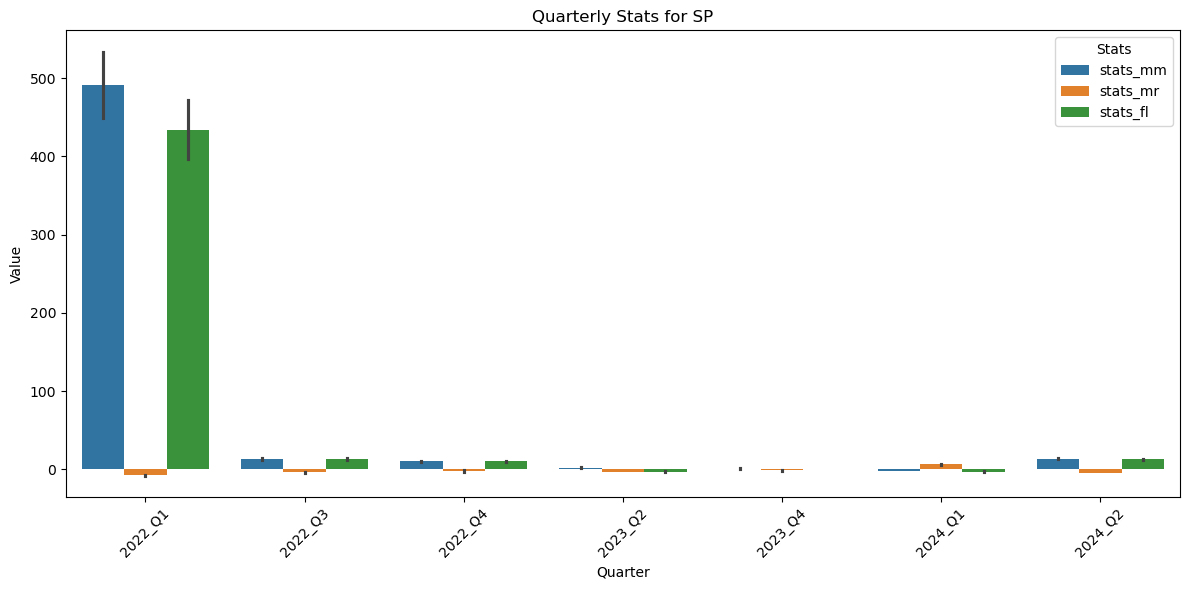

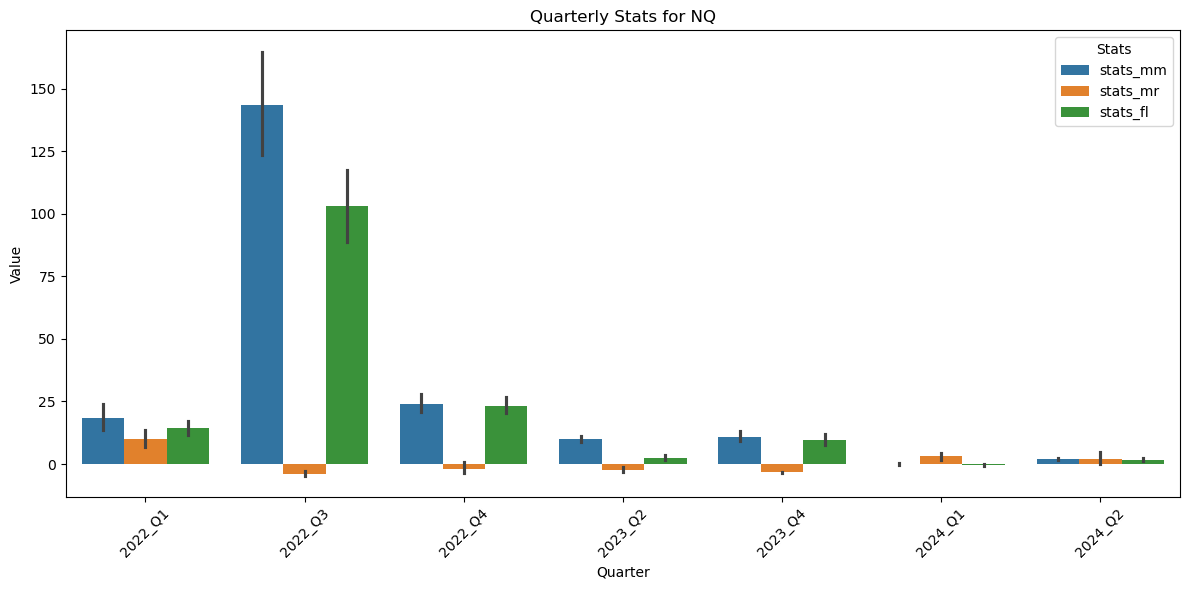

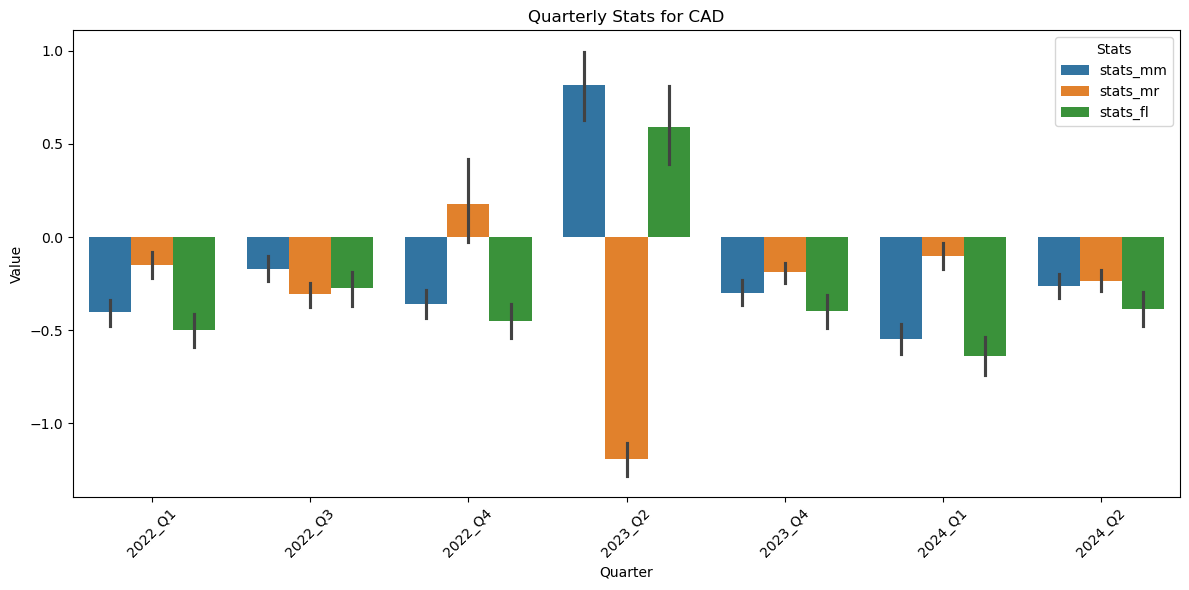

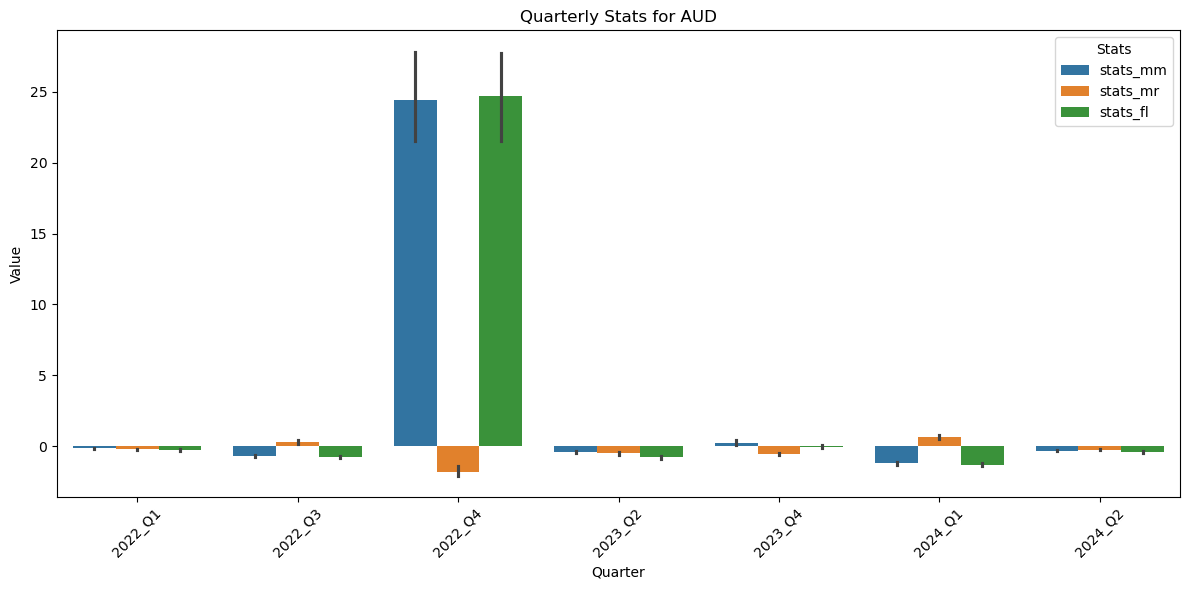

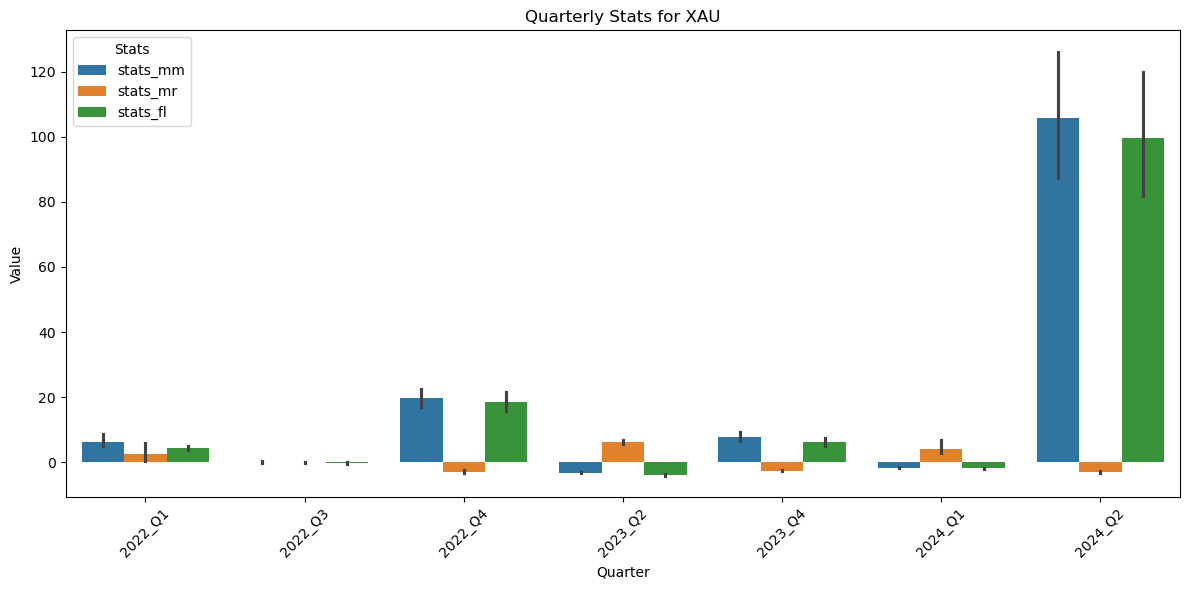

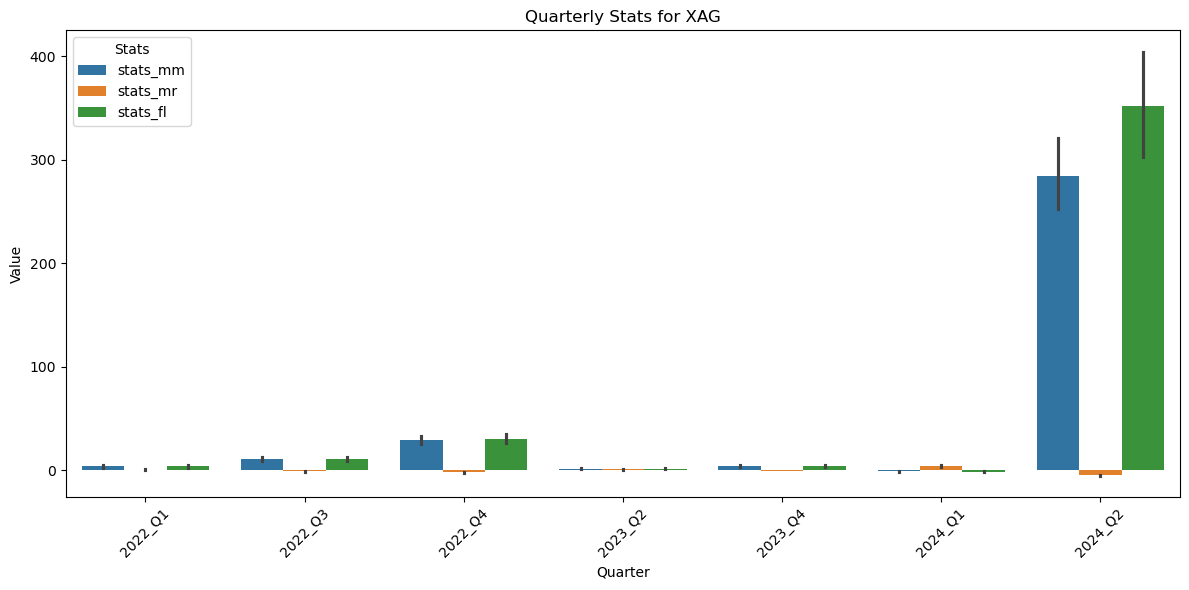

In [406]:
df = vb2_results
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


# 2VB

## GR1

In [407]:
# df = vb2_gr1.query("instrument_name == 'NQ' and max_mean_stats>100")
# params = {x:y for x,y in df.reset_index().to_dict(orient="records")[0].items() if "stat" not in x}
# query_conditions = []
# for key, value in params.items():
#     if isinstance(value, int):
#         query_conditions.append(f"{key} == {value}")
#     elif isinstance(value, float):
#         query_conditions.append(f"{key} == {round(value, 5)}")
#     elif isinstance(value, str):
#         query_conditions.append(f"{key} == '{value}'")
# query = " and ".join(query_conditions)
# vb2_results.query(query)

In [408]:
import seaborn as sns

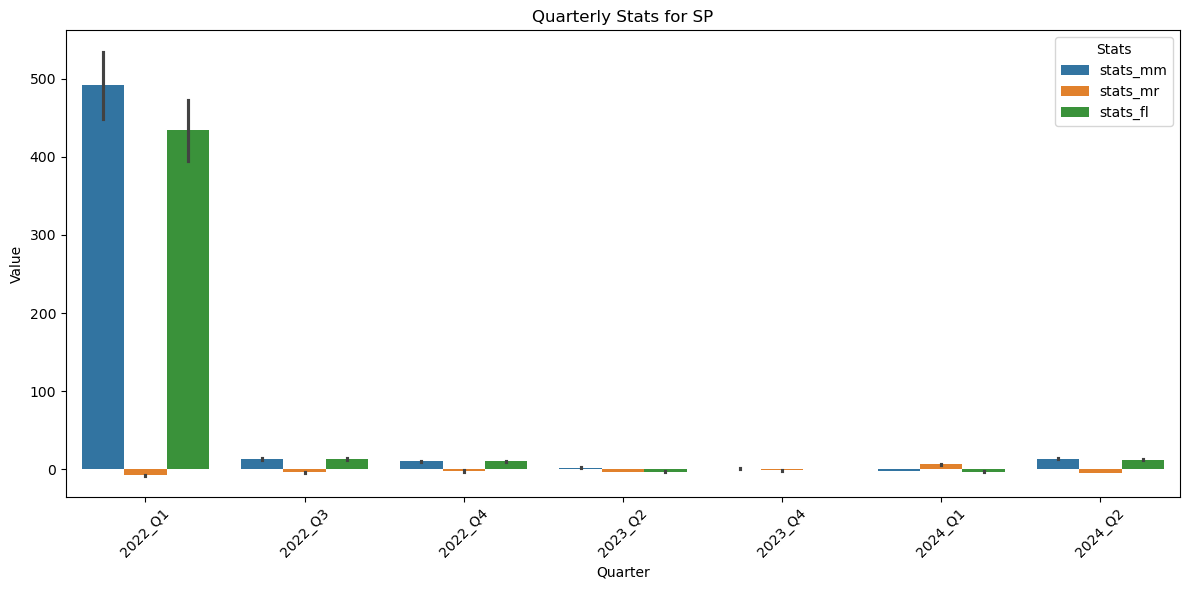

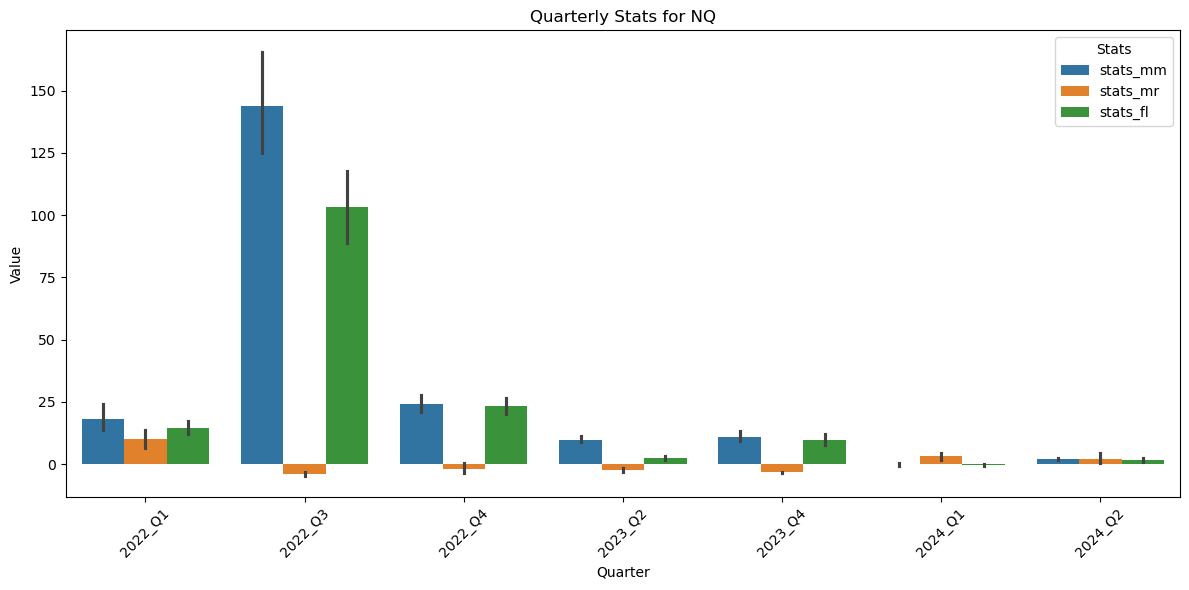

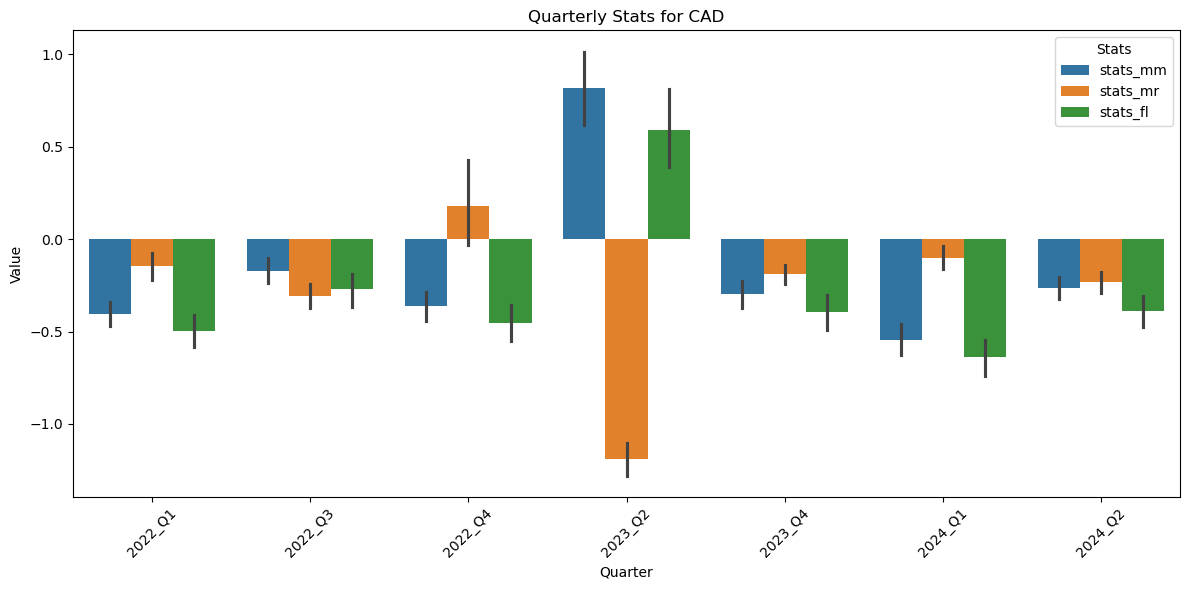

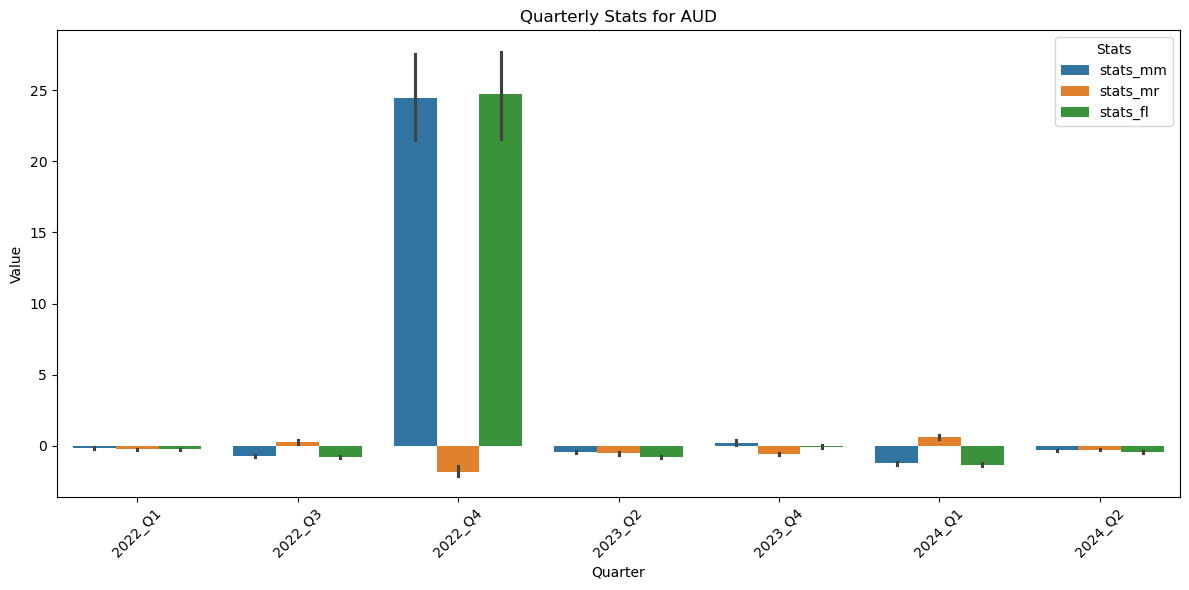

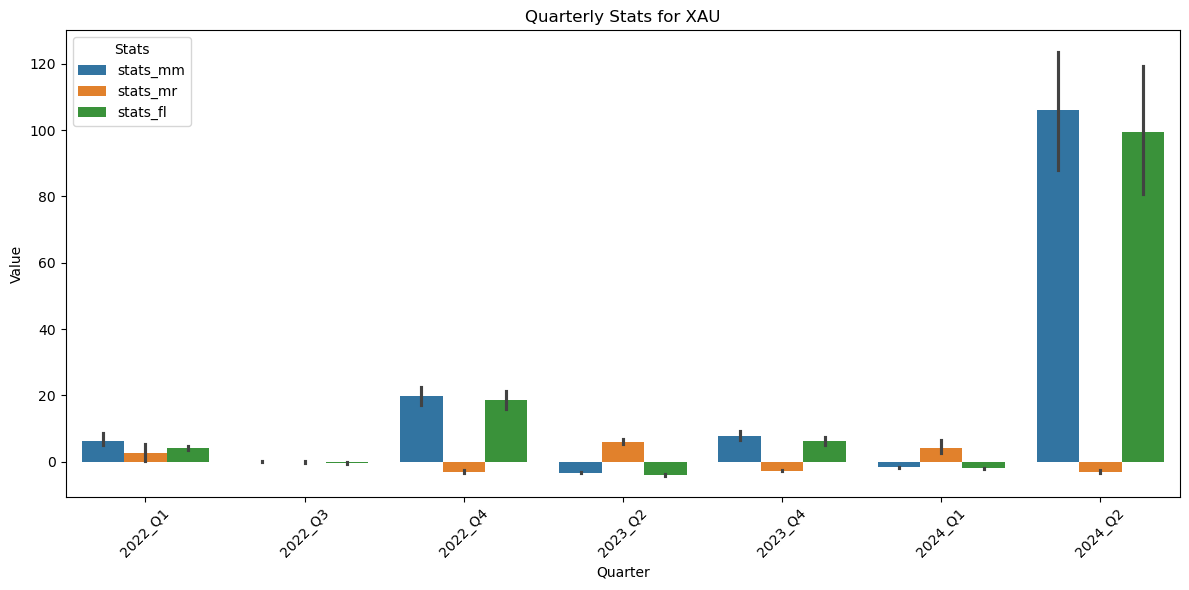

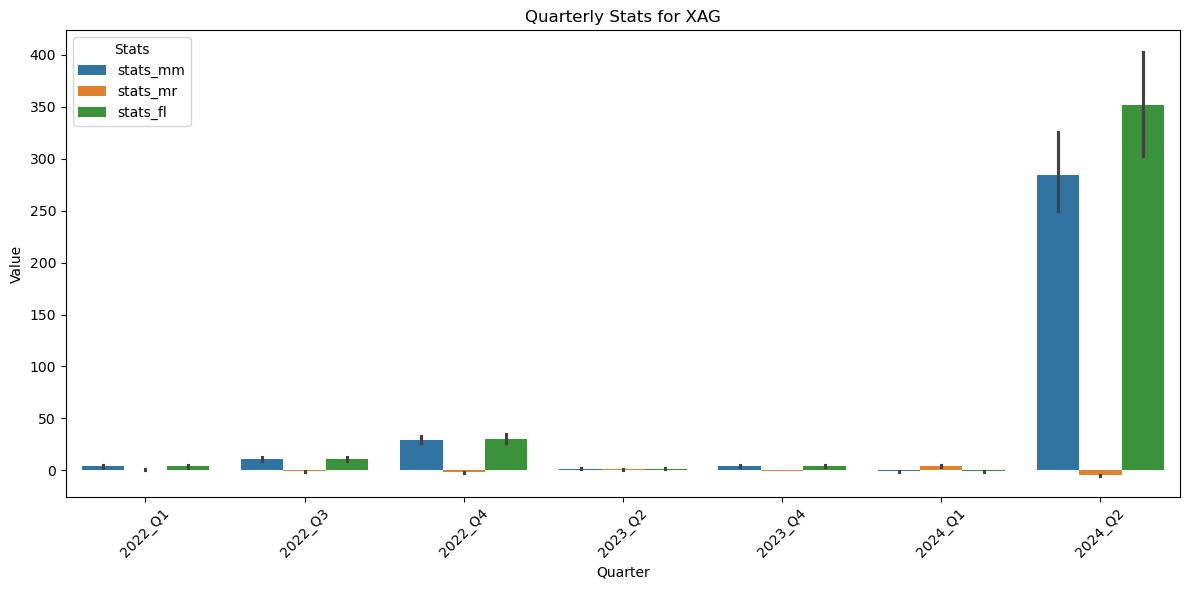

In [409]:
df = vb2_results
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


In [415]:
vb2_gr1.query("instrument_name == 'NQ' and max_mean_stats> 300").sort_values("max_mean_stats_corr",ascending=False).head(5)

,,,,,,,,,,,,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
53,61,mean,93,0.08141,68,1.95906,0.77728,NQ,1,20,12,442.896964,905.863199,-5.693438,4.808536,285.066982,549.149763,-10.034635,-8.097705,10.492101,442.896964,10.492101
55,58,mean,96,0.10908,69,2.07370,0.63202,NQ,1,20,12,305.569831,705.902712,-4.948390,4.707258,123.586893,233.477794,-47.381525,-7.302019,6.847996,305.569831,6.847996
19,49,mean,66,0.19143,49,1.50439,0.95081,NQ,1,20,12,342.462001,881.145300,0.833184,9.251636,116.426571,286.492965,-98.110649,-3.792634,-26.819911,342.462001,-3.792634
54,70,mean,98,0.09061,70,1.78309,1.20501,NQ,1,20,12,339.727032,889.330319,-3.813092,3.543801,204.010480,533.494963,-104.938128,-5.584993,-62.737002,339.727032,-5.584993
60,76,mean,50,0.00080,80,2.28469,0.70020,NQ,1,20,12,337.045404,863.503490,-2.856605,5.945851,337.387367,869.178161,-94.706341,-5.829531,-97.201713,337.387367,-5.829531


## GR2

In [366]:
df = vb2_gr1.query("instrument_name == 'NQ' and max_mean_stats>100")
params = {x:y for x,y in df.reset_index().to_dict(orient="records")[0].items() if "stat" not in x}
query_conditions = []
for key, value in params.items():
    if isinstance(value, int):
        query_conditions.append(f"{key} == {value}")
    elif isinstance(value, float):
        query_conditions.append(f"{key} == {round(value, 5)}")
    elif isinstance(value, str):
        query_conditions.append(f"{key} == '{value}'")
query = " and ".join(query_conditions)
vb2_results.query(query)

UndefinedVariableError: name 'max_mean_stats' is not defined

In [269]:
vb2_gr2.groupby("instrument_name").max()

,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
instrument_name,,,,,,,,,,,
AUD,51.222663,135.865433,7.975637,23.128459,52.131313,138.234039,0.0,0.0,0.0,52.131313,0.0
CAD,2.659762,7.037069,2.795905,7.397270,2.659762,7.037069,0.0,0.0,0.0,2.795905,0.0
XAG,910.096293,2352.483124,47.743982,98.272108,1425.075120,3711.936241,0.0,0.0,0.0,1425.075120,0.0
XAU,262.726756,640.524186,176.498080,457.451423,284.379256,650.997626,0.0,0.0,0.0,284.379256,0.0


In [257]:
vb2_gr2.query("instrument_name == 'XAG' and max_mean_stats>100").head(10)

,,,,,,,,,,,,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
56,86,mean,96,0.73922,79,1.99152,2.08433,XAG,2,5000,10,141.497098,371.295583,-1.266561,2.045978,0.888089,2.349663,-972.389651,-7.404496,-6.160899,141.497098,-6.160899
50,86,mean,24,0.44613,78,1.88604,1.87570,XAG,2,5000,10,277.623811,734.523561,-0.844912,1.905237,13.650894,35.160574,-1925.946871,-6.560622,-91.830830,277.623811,-6.560622
58,88,mean,95,0.06491,75,2.07075,2.07974,XAG,2,5000,10,301.445347,795.805271,-1.003087,1.885158,301.445347,795.805271,-2085.970466,-6.658562,-2085.970466,301.445347,-6.658562
50,84,mean,96,0.03999,76,1.93119,2.00781,XAG,2,5000,10,114.368338,280.071504,-0.910843,1.936927,114.368338,280.071504,-725.846173,-6.721623,-725.846173,114.368338,-6.721623
58,88,mean,98,0.06454,75,2.07752,2.17450,XAG,2,5000,10,304.385017,803.357962,-1.019055,1.901025,304.385017,803.357962,-2105.688870,-6.722130,-2105.688870,304.385017,-6.722130
51,96,mean,99,0.01854,74,2.58528,1.76935,XAG,2,5000,10,300.951343,794.256456,-1.025995,1.901483,300.951343,794.256456,-2081.818024,-6.730443,-2081.818024,300.951343,-6.730443
54,91,mean,100,0.57553,77,1.79407,2.12775,XAG,2,5000,10,288.962597,764.366223,-0.946237,1.931311,288.983644,764.356958,-2004.136073,-6.740172,-2004.087230,288.983644,-6.740172
52,84,mean,98,0.03999,74,1.85519,2.01408,XAG,2,5000,10,105.402927,277.914377,-1.011946,1.912819,105.402927,277.914377,-728.340206,-6.750403,-728.340206,105.402927,-6.750403
58,80,mean,90,0.03319,77,2.08827,2.07626,XAG,2,5000,10,277.389956,732.893899,-1.083311,1.909416,277.401967,732.888639,-1921.291739,-6.811559,-1921.263951,277.401967,-6.811559


In [258]:
vb2_gr2.query("instrument_name == 'XAU' and max_mean_stats>100").head(10)

stats_mm_mean  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                  
55      53      median           13            0.49740         77          0.21472 1.81627 XAU             2          100   15          184.371915   
57      59      median           20            0.58009         74          0.17137 1.97721 XAU             2          100   15          193.593772   
58      55      median           25            0.54250         73          0.11303 2.00174 XAU             2          100   15          232.312526   
56      54      median           24            0.54211         72          0.11808 2.08558 XAU             2          100   15          165.937519   
54      60      median           18            0.57665         73          0.18732 2.01904 XAU             2          100   15          193.593772   
38      45      median           97            0.36009         57          0.49023 1.54379 XAU             2          100   15          220.303031   
57      53      median           31            0.54908         74          0.18141 1.93953 XAU             2          100   15          165.937519   
        55      median           21            0.51121         73          0.27112 1.91871 XAU             2          100   15          168.665502   
55      56      median           20            0.56948         71          0.11382 2.03951 XAU             2          100   15          210.789733   
58      55      median           24            0.54877         73          0.10705 1.97748 XAU             2          100   15          210.788033   

                                                                                                                                     stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                 
55      53      median           13            0.49740         77          0.21472 1.81627 XAU             2          100   15         488.147257   
57      59      median           20            0.58009         74          0.17137 1.97721 XAU             2          100   15         474.205958   
58      55      median           25            0.54250         73          0.11303 2.00174 XAU             2          100   15         519.466601   
56      54      median           24            0.54211         72          0.11808 2.08558 XAU             2          100   15         439.029408   
54      60      median           18            0.57665         73          0.18732 2.01904 XAU             2          100   15         474.205958   
38      45      median           97            0.36009         57          0.49023 1.54379 XAU             2          100   15         493.566641   
57      53      median           31            0.54908         74          0.18141 1.93953 XAU             2          100   15         439.029408   
        55      median           21            0.51121         73          0.27112 1.91871 XAU             2          100   15         437.884314   
55      56      median           20            0.56948         71          0.11382 2.03951 XAU             2          100   15         516.327289   
58      55      median           24            0.54877         73          0.10705 1.97748 XAU             2          100   15         516.328122   

                                                                                                                                     stats_mr_mean  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                  
55      53      median           13            0.49740         77          0.21472 1.81627 XAU             2          100   15           -0.667483   
57      59      median           20            0.58009         74          0.17137 1.97721 XA

# VB

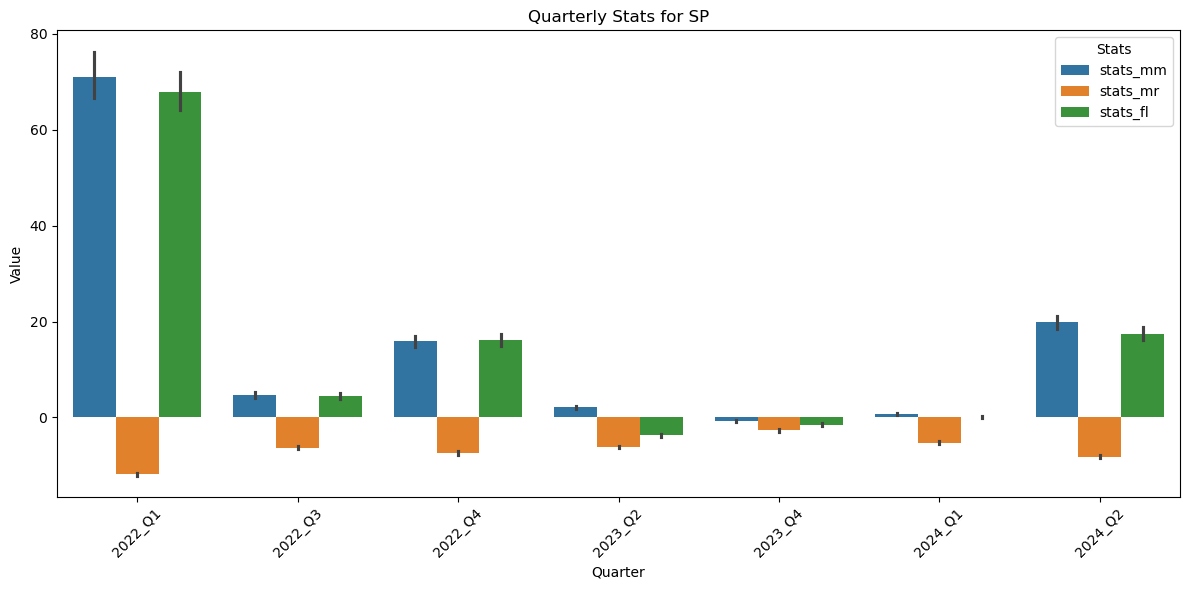

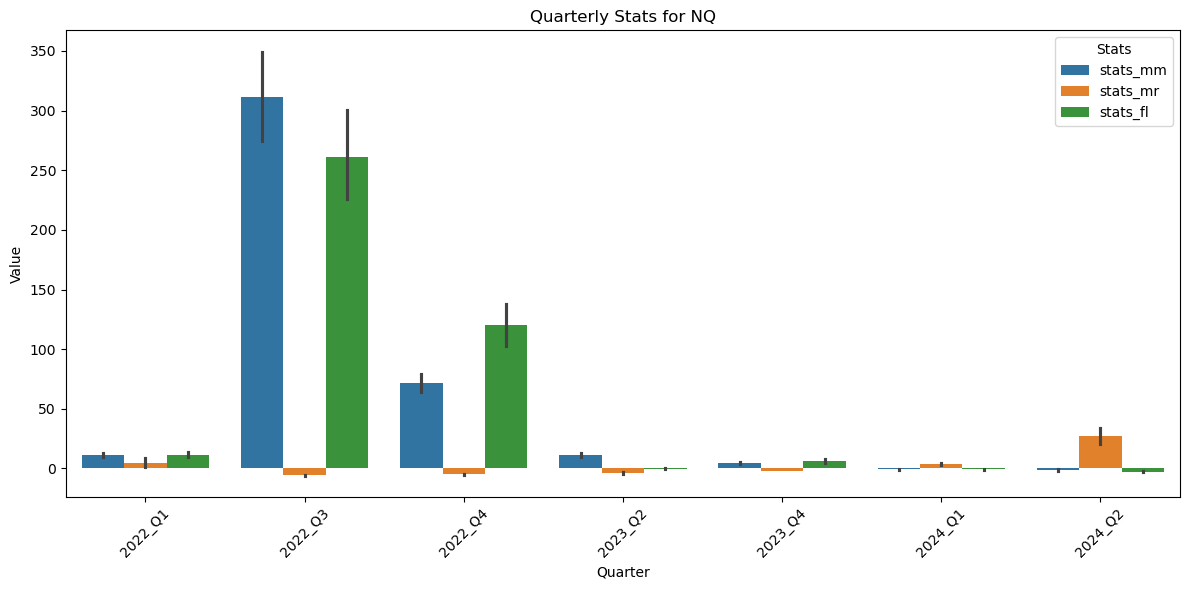

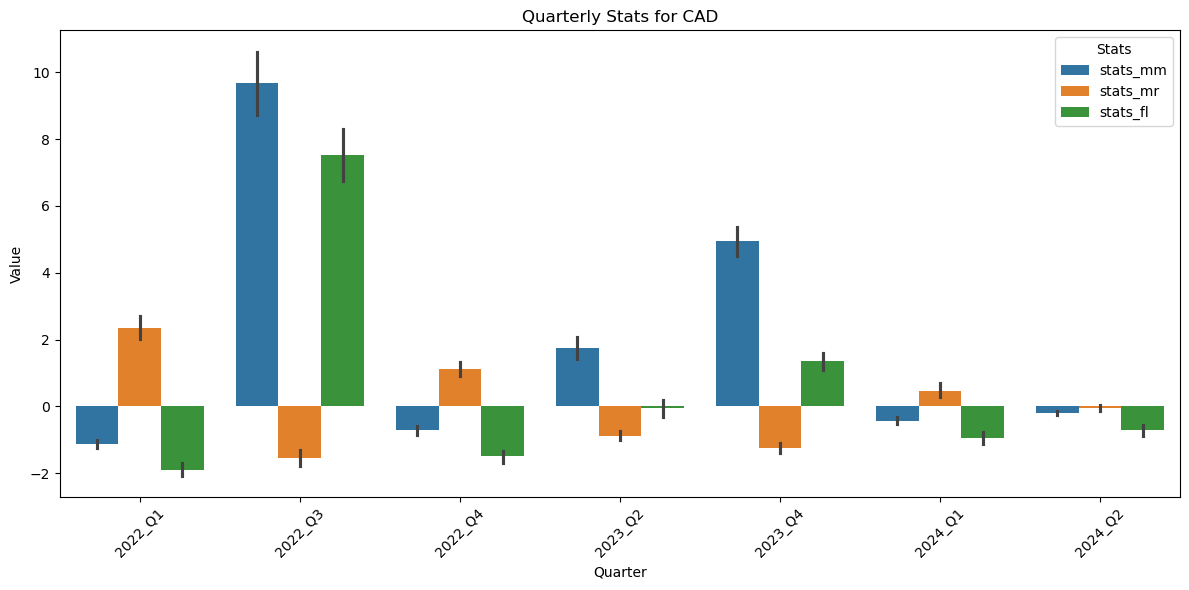

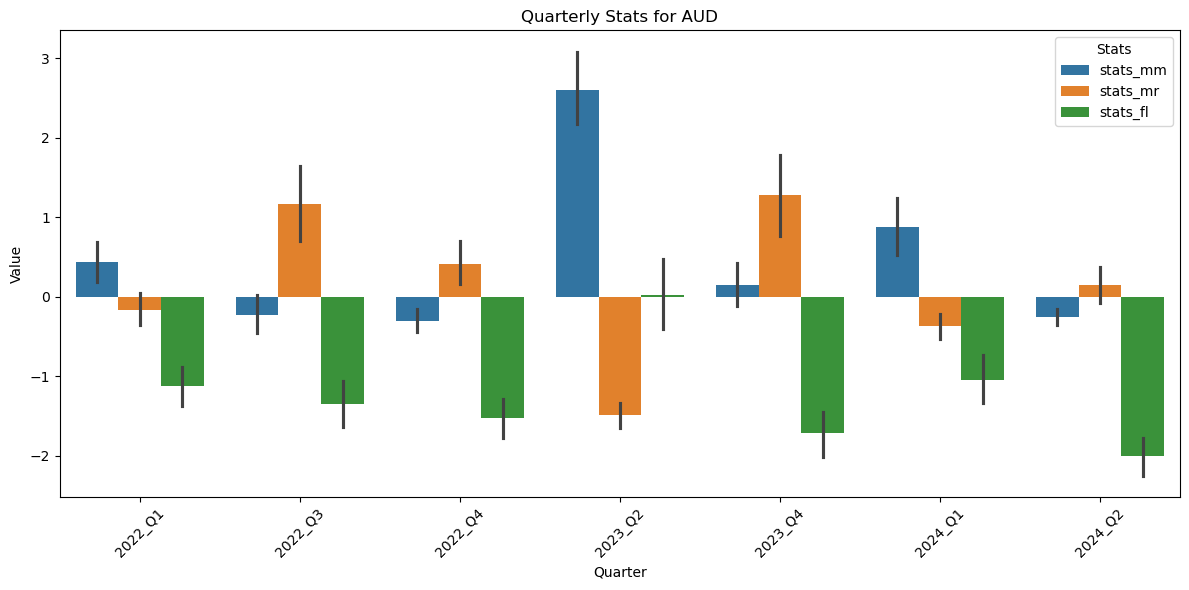

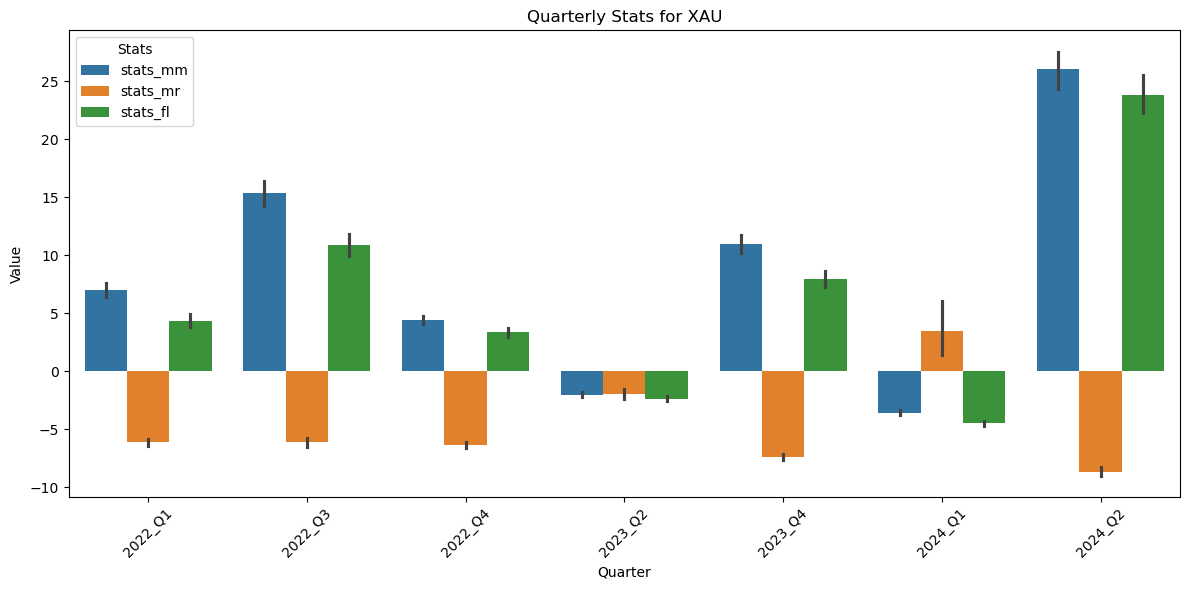

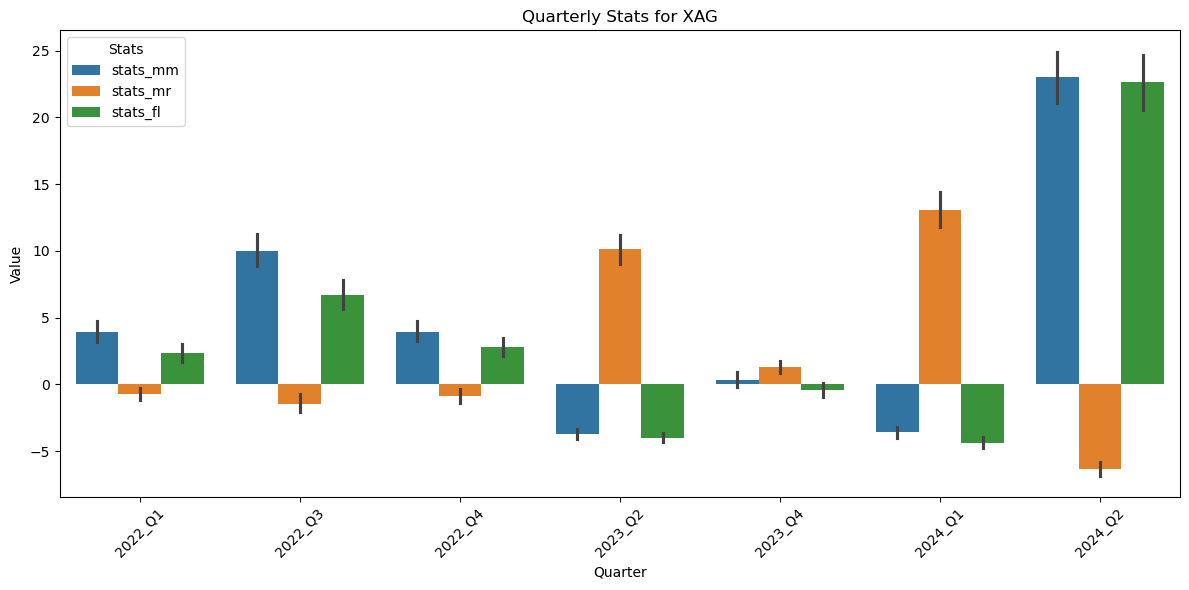

In [308]:
df = vb_results
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


## GR1

In [380]:
vb2_gr1.query("instrument_name == 'SP'").sort_values("max_sum_stats_corr", ascending=False).head(3)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                 
27      88      mean             33            0.08135         54          2.82341 2.49484 SP              1          50    12         500.051671   
36      82      mean             31            0.01315         55          2.83336 2.20957 SP              1          50    12         509.958567   
        84      mean             23            0.05155         54          2.93890 2.37545 SP              1          50    12         606.275921   

                                                                                                                                     stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                 
27      88      mean             33            0.08135         54          2.82341 2.49484 SP              1          50    12         104.780817   
36      82      mean             31            0.01315         55          2.83336 2.20957 SP              1          50    12         104.984195   
        84      mean             23            0.05155         54          2.93890 2.37545 SP              1          50    12         139.392630   

                                                                                                                                     stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                 
27      88      mean             33            0.08135         54          2.82341 2.49484 SP              1          50    12         -18.172031   
36      82      mean             31            0.01315         55          2.83336 2.20957 SP              1          50    12         -20.239578   
        84      mean             23            0.05155         54          2.93890 2.37545 SP              1          50    12         -20.571658   

                                                                                                                                     stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                 
27      88      mean             33            0.08135         54          2.82341 2.49484 SP              1          50    12           2.855257   
36      82      mean             31            0.01315         55          2.83336 2.20957 SP              1          50    12           4.216750   
        84      mean             23            0.05155         54          2.93890 2.37545 SP              1          50    12           4.069156   

                                                                                                                                     stats_fl_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                 
27      88      mean             33            0.08135         54          2.82341 2.49484 SP              1          50    12         625.930206   
36      82      mean             31            0.01315         55          2.83336 2.20957 SP              1          50    12         502.678508   
        84      mean             23            0.05155         54          2.93890 2.37545 SP              1          50    12         911.060916   

                                                                                                                                     stats_fl_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_exit  m_diff  instrument_name group_data p_val tr_cost                 
27      88      mean             33            0.08135         54          2.82341 2.49484 SP            

In [345]:
df = vb2_gr1.query("instrument_name == 'SP'").sort_values("max_sum_stats", ascending=False).head(3)
params = {x:y for x,y in df.reset_index().to_dict(orient="records")[0].items() if "stat" not in x}
query_conditions = []
for key, value in params.items():
    if isinstance(value, int):
        query_conditions.append(f"{key} == {value}")
    elif isinstance(value, float):
        query_conditions.append(f"{key} == {round(value, 5)}")
    elif isinstance(value, str):
        query_conditions.append(f"{key} == '{value}'")
query = " and ".join(query_conditions)
vb2_results.query(query)

,selected_quarter,fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,stats_mm,stats_mr,stats_fl
9989,2022_Q1,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,3546.016742,-9.085911,6166.964411
9990,2022_Q3,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,0.538328,-1.182787,0.538328
9991,2022_Q4,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,2.408703,-3.421650,2.408703
9992,2023_Q2,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,0.000000,-1.870886,-2.607497
9993,2023_Q4,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,0.000000,0.000000,0.000000
9994,2024_Q1,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,-4.124578,10.130604,-4.193181
9995,2024_Q2,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,16.545859,-4.843227,15.982410


In [ ]:
vb_gr1.query("instrument_name == 'SP'").sort_values("max_sum_stats", ascending=False).head(5)

,,,,,,,,,,,stats_mm_sum,stats_mm_std,stats_mr_sum,stats_mr_std,stats_fl_sum,stats_fl_std,stats_mm_sum_corr,stats_mr_sum_corr,stats_fl_sum_corr,max_sum_stats,max_sum_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
39,44,mean,68,0.65503,68,1.41443,SP,1,50,12,1334.319828,483.593785,-25.762721,3.306332,881.778228,317.773326,-116.461526,-35.681716,-71.541749,1334.319828,-35.681716
34,47,mean,2,0.40948,51,2.72371,SP,1,50,12,1019.655651,342.493810,-27.240502,3.226409,-80.262825,3.521749,-7.825778,-36.919729,-90.828072,1019.655651,-7.825778
20,44,mean,70,0.19575,52,1.86294,SP,1,50,12,503.986937,192.563497,1.385541,4.956831,153.051154,62.417613,-73.703555,-13.484954,-34.201686,503.986937,-13.484954
19,56,median,38,0.11787,90,1.59321,SP,1,50,12,279.844296,60.937771,-45.290811,6.463354,268.970614,61.531379,97.030983,-64.680872,84.376476,279.844296,97.030983
36,48,median,83,0.35482,15,2.65307,SP,1,50,12,277.108433,60.201942,-61.324918,4.563078,268.779106,60.572255,96.502608,-75.014151,87.062340,277.108433,96.502608


In [377]:
vb2_gr1.query("instrument_name == 'NQ'").sort_values("max_sum_stats", ascending=False).head(2)

,,,,,,,,,,,,stats_mm_sum,stats_mm_std,stats_mr_sum,stats_mr_std,stats_fl_sum,stats_fl_std,stats_mm_sum_corr,stats_mr_sum_corr,stats_fl_sum_corr,max_sum_stats,max_sum_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
54,71,mean,54,0.01686,72,2.08637,0.76097,NQ,1,20,12,3166.547176,1185.060970,-29.120341,4.031330,3157.284368,1185.640283,-388.635733,-41.214331,-399.636480,3166.547176,-41.214331
53,61,mean,93,0.08141,68,1.95906,0.77728,NQ,1,20,12,3100.278750,905.863199,-39.854063,4.808536,1995.468876,549.149763,382.689153,-54.279670,348.019588,3100.278750,382.689153


In [376]:
vb_gr1.query("instrument_name == 'NQ'").sort_values("max_sum_stats", ascending=False).head(10)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12        3622.183253   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12        3821.587220   
54      58      mean             42            0.67346         68          2.63429 NQ              1          20    12        2471.126905   
56      56      mean             40            0.65389         68          2.61641 NQ              1          20    12        2571.602898   
57      57      mean             40            0.66324         68          2.66351 NQ              1          20    12        2127.440003   
                                               0.64827         68          2.66573 NQ              1          20    12        2127.538199   
                                               0.65920         69          2.65913 NQ              1          20    12        2314.183911   
53      56      mean             42            0.62494         67          2.57739 NQ              1          20    12        1854.009806   
57      57      mean             40            0.67009         70          2.60777 NQ              1          20    12        2312.153399   
55      58      mean             44            0.61233         68          2.73932 NQ              1          20    12        2431.594387   

                                                                                                                             stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12        1262.877839   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12        1317.241286   
54      58      mean             42            0.67346         68          2.63429 NQ              1          20    12         734.602856   
56      56      mean             40            0.65389         68          2.61641 NQ              1          20    12         806.907190   
57      57      mean             40            0.66324         68          2.66351 NQ              1          20    12         599.425541   
                                               0.64827         68          2.66573 NQ              1          20    12         599.417219   
                                               0.65920         69          2.65913 NQ              1          20    12         771.795128   
53      56      mean             42            0.62494         67          2.57739 NQ              1          20    12         507.034066   
57      57      mean             40            0.67009         70          2.60777 NQ              1          20    12         776.551802   
55      58      mean             44            0.61233         68          2.73932 NQ              1          20    12         786.956673   

                                                                                                                             stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12         -36.075071   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12         -33.606583   
54      58      mean             42            0.67346         68          2.63429 NQ              1          20    12         -38.597151   
56      56      mean             4

## GR2

In [375]:
vb_gr2

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val  tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000   10         -39.292773   
31      57      median           96            0.03678         13          0.41912 XAU             2          100    15         141.337227   
                                 98            0.01932         13          0.41566 XAU             2          100    15         141.556677   
33      55      median           94            0.04843         11          0.47290 XAU             2          100    15         167.972290   
31      57      median           96            0.42679         9           0.53374 XAU             2          100    15         155.701073   
...                                                                                                                                    ...   
1       60      mean             19            0.53968         57          0.42901 CAD             2          100000 10         -48.260908   
7       23      mean             32            0.46923         2           2.78928 CAD             2          100000 10         -53.264491   
1       26      mean             79            0.54473         3           2.54723 AUD             2          100000 10         -51.544701   
9       4       mean             69            0.00233         4           0.93453 CAD             2          100000 10         -60.663709   
1       1       mean             36            0.37124         40          0.15566 CAD             2          100000 10         -96.509485   

                                                                                                                              stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val  tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000   10           3.815484   
31      57      median           96            0.03678         13          0.41912 XAU             2          100    15          22.862019   
                                 98            0.01932         13          0.41566 XAU             2          100    15          23.041489   
33      55      median           94            0.04843         11          0.47290 XAU             2          100    15          31.849951   
31      57      median           96            0.42679         9           0.53374 XAU             2          100    15          27.774240   
...                                                                                                                                    ...   
1       60      mean             19            0.53968         57          0.42901 CAD             2          100000 10           1.057761   
7       23      mean             32            0.46923         2           2.78928 CAD             2          100000 10           0.498037   
1       26      mean             79            0.54473         3           2.54723 AUD             2          100000 10           0.607368   
9       4       mean             69            0.00233         4           0.93453 CAD             2          100000 10           0.804748   
1       1       mean             36            0.37124         40          0.15566 CAD             2          100000 10           0.395616   

                                                                                                                              stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val  tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000   10         206.801144   
31    

In [367]:
vb_gr2.query("instrument_name == 'XAG'").head(5)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000  10         -39.292773   
59      8       median           77            0.18152         28          1.29500 XAG             2          5000  10         202.112547   
                                 78            0.36401         28          1.26730 XAG             2          5000  10         174.062422   
58      8       median           76            0.40695         25          1.41026 XAG             2          5000  10         165.568136   
62      8       median           75            0.21740         29          1.28927 XAG             2          5000  10         118.905164   

                                                                                                                             stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000  10           3.815484   
59      8       median           77            0.18152         28          1.29500 XAG             2          5000  10          45.875541   
                                 78            0.36401         28          1.26730 XAG             2          5000  10          39.058347   
58      8       median           76            0.40695         25          1.41026 XAG             2          5000  10          36.424367   
62      8       median           75            0.21740         29          1.28927 XAG             2          5000  10          21.933529   

                                                                                                                             stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000  10         206.801144   
59      8       median           77            0.18152         28          1.29500 XAG             2          5000  10         -14.459125   
                                 78            0.36401         28          1.26730 XAG             2          5000  10         -13.480239   
58      8       median           76            0.40695         25          1.41026 XAG             2          5000  10         -33.947474   
62      8       median           75            0.21740         29          1.28927 XAG             2          5000  10         -20.034132   

                                                                                                                             stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000  10          36.658822   
59      8       median           77            0.18152         28          1.29500 XAG             2          5000  10          10.098961   
                                 78            0.36401         28          1.26730 XAG             2          5000  10          10.047042   
58      8       median           76            0.40695         25          1.41026 XAG             2          5000  10           5.789406   
62      8       median           75            0.21740         29          1.28927 XAG             2          5000  10           9.197337   

                                                                                                                             stats_fl_sum  \
fast_ma ma_diff signal_estimator

In [368]:
vb_gr2.query("instrument_name == 'XAU'").head(5)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
31      57      median           96            0.03678         13          0.41912 XAU             2          100   15         141.337227   
                                 98            0.01932         13          0.41566 XAU             2          100   15         141.556677   
33      55      median           94            0.04843         11          0.47290 XAU             2          100   15         167.972290   
31      57      median           96            0.42679         9           0.53374 XAU             2          100   15         155.701073   
        56      median           96            0.04157         11          0.39932 XAU             2          100   15         158.772483   

                                                                                                                             stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
31      57      median           96            0.03678         13          0.41912 XAU             2          100   15          22.862019   
                                 98            0.01932         13          0.41566 XAU             2          100   15          23.041489   
33      55      median           94            0.04843         11          0.47290 XAU             2          100   15          31.849951   
31      57      median           96            0.42679         9           0.53374 XAU             2          100   15          27.774240   
        56      median           96            0.04157         11          0.39932 XAU             2          100   15          28.901782   

                                                                                                                             stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
31      57      median           96            0.03678         13          0.41912 XAU             2          100   15         -54.543147   
                                 98            0.01932         13          0.41566 XAU             2          100   15         -51.326678   
33      55      median           94            0.04843         11          0.47290 XAU             2          100   15         -56.592853   
31      57      median           96            0.42679         9           0.53374 XAU             2          100   15         -56.453262   
        56      median           96            0.04157         11          0.39932 XAU             2          100   15         -53.479338   

                                                                                                                             stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
31      57      median           96            0.03678         13          0.41912 XAU             2          100   15           4.664527   
                                 98            0.01932         13          0.41566 XAU             2          100   15           5.840918   
33      55      median           94            0.04843         11          0.47290 XAU             2          100   15           4.134983   
31      57      median           96            0.42679         9           0.53374 XAU             2          100   15           4.232992   
        56      median           96            0.04157         11          0.39932 XAU             2          100   15           5.000794   

                                                                                                                             stats_fl_sum  \
fast_ma ma_diff signal_estimator

# MA

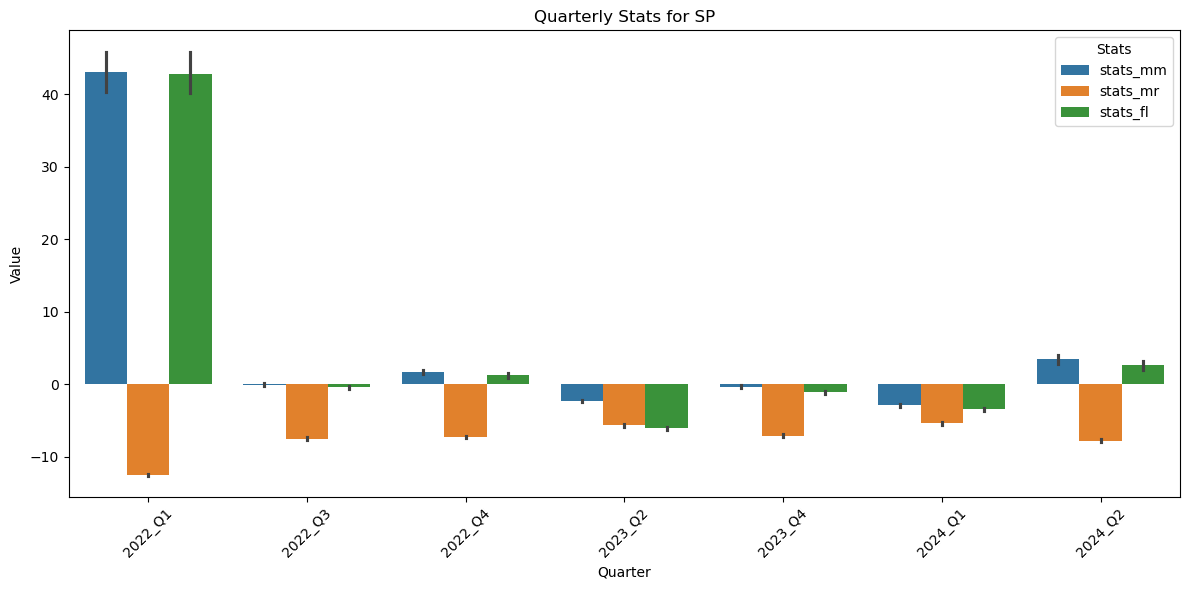

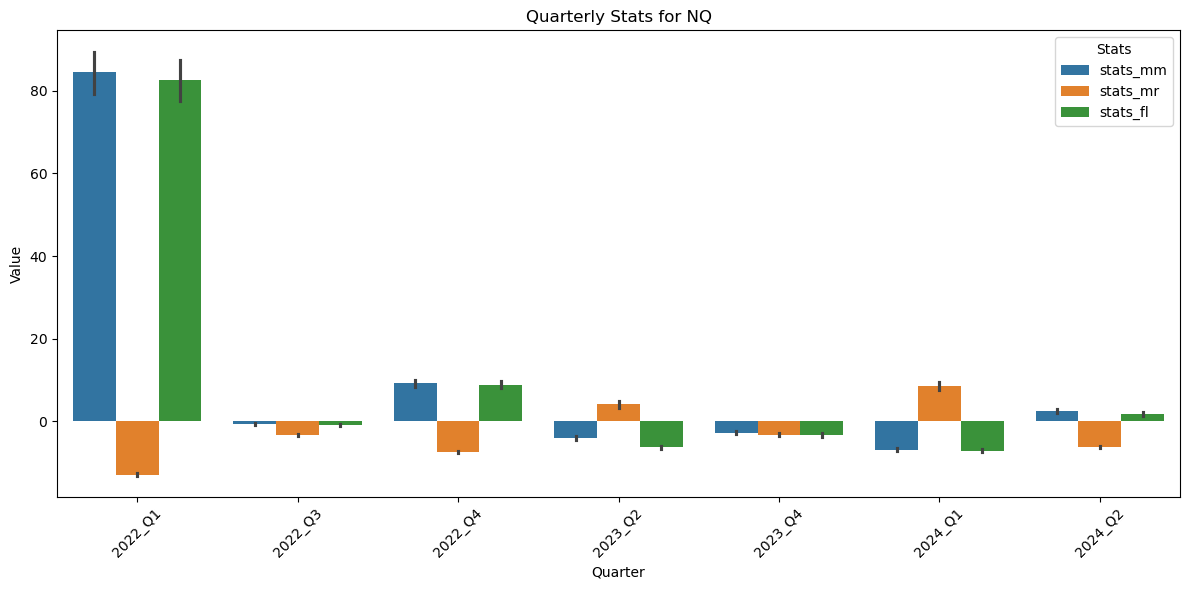

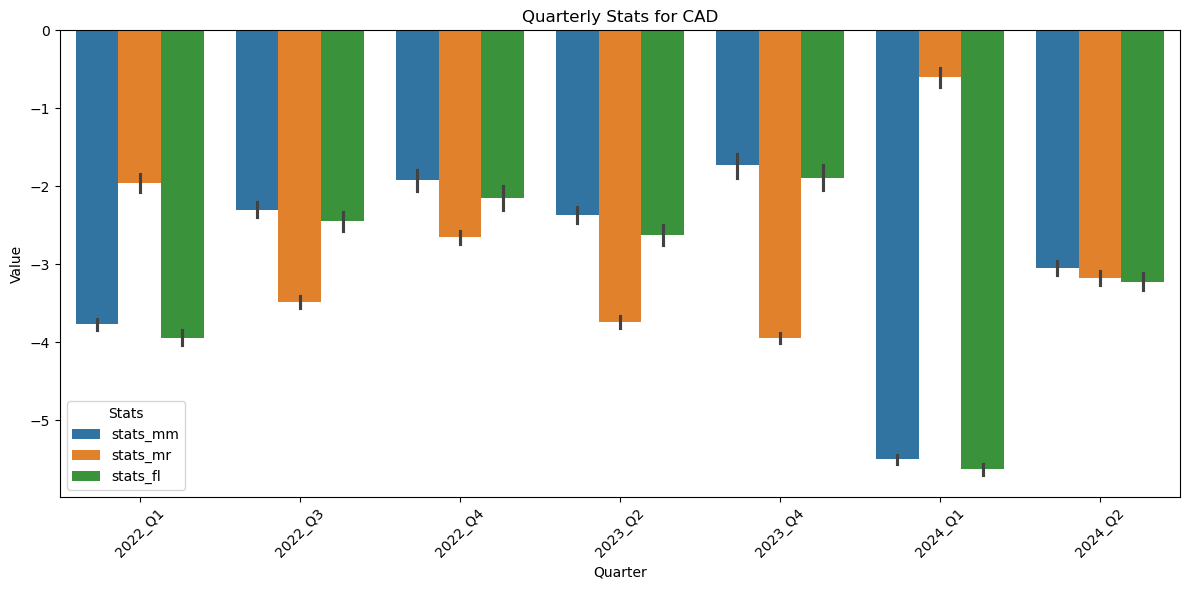

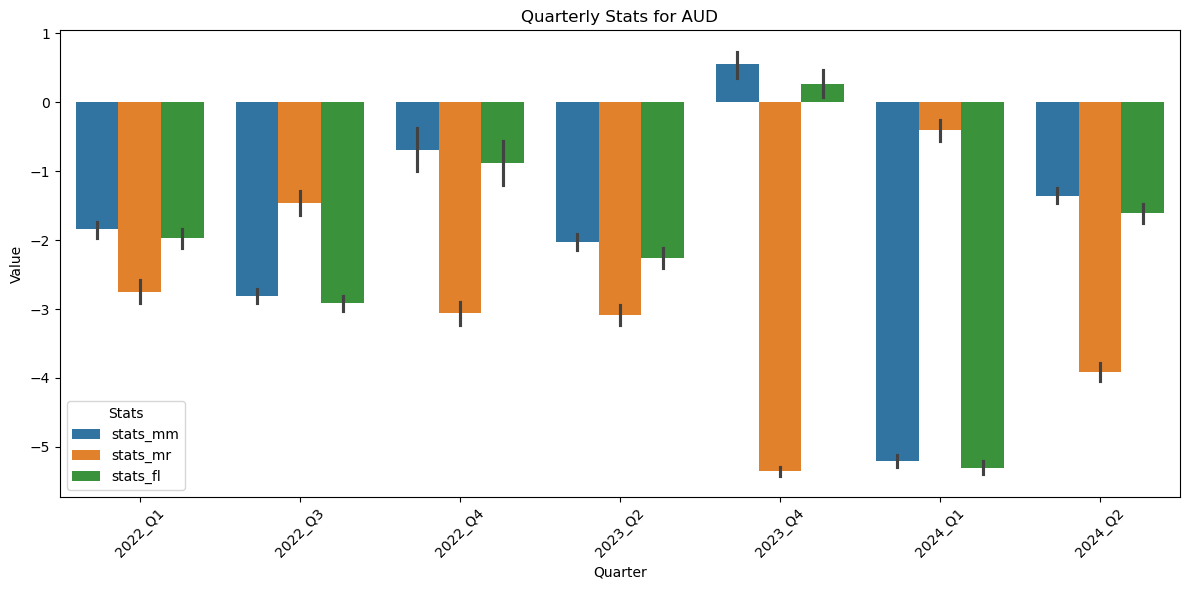

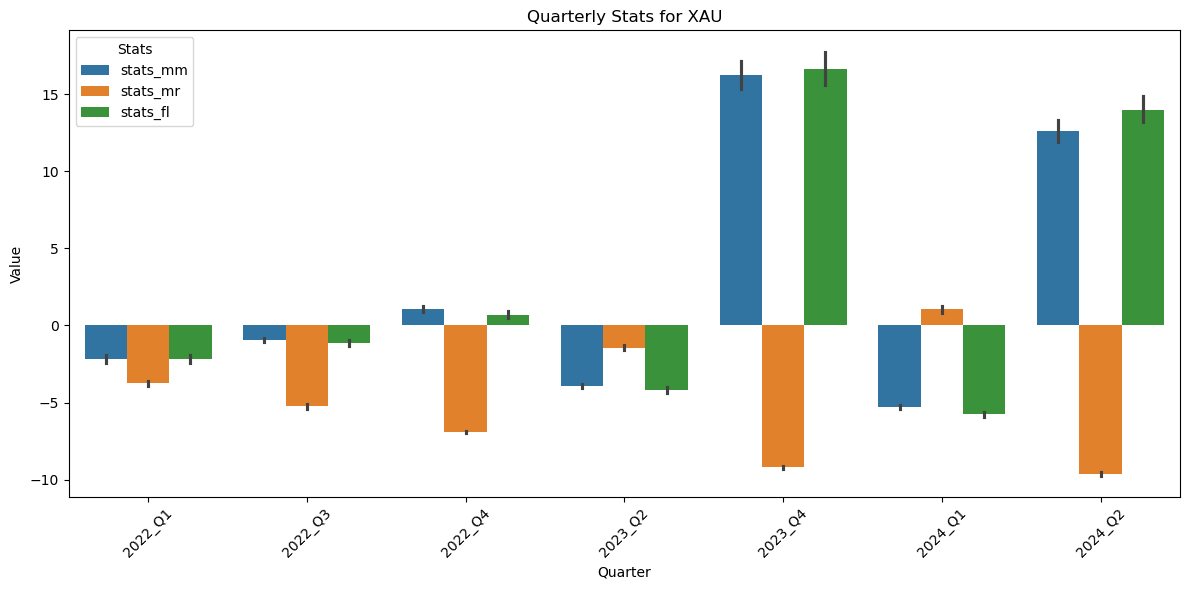

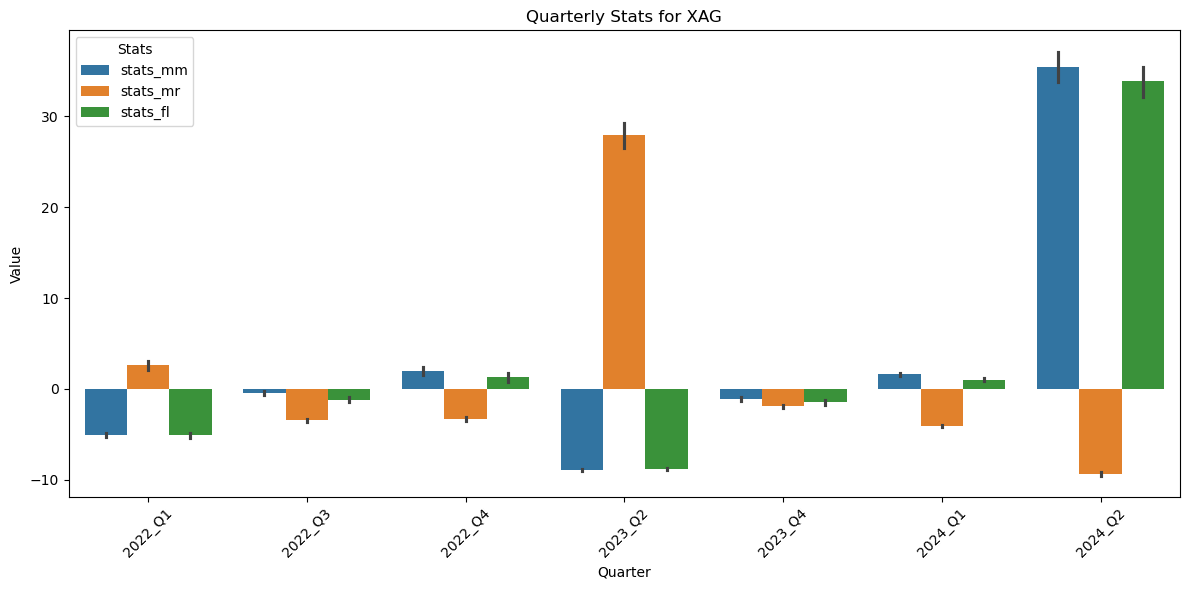

In [369]:
df = ma_results
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


## GR1

In [370]:
ma_gr1.query("instrument_name == 'SP'").head(5)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12          42.412702   
                                 77            0.27054         SP              1          50    12          42.412702   
                                               0.27517         SP              1          50    12          42.412702   
                                               0.29854         SP              1          50    12          42.412702   
                                               0.31070         SP              1          50    12          42.412702   

                                                                                                         stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12           8.910585   
                                 77            0.27054         SP              1          50    12           8.910585   
                                               0.27517         SP              1          50    12           8.910585   
                                               0.29854         SP              1          50    12           8.910585   
                                               0.31070         SP              1          50    12           8.910585   

                                                                                                         stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12          -74.93162   
                                 77            0.27054         SP              1          50    12          -74.93162   
                                               0.27517         SP              1          50    12          -74.93162   
                                               0.29854         SP              1          50    12          -74.93162   
                                               0.31070         SP              1          50    12          -74.93162   

                                                                                                         stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12           1.650516   
                                 77            0.27054         SP              1          50    12           1.650516   
                                               0.27517         SP              1          50    12           1.650516   
                                               0.29854         SP              1          50    12           1.650516   
                                               0.31070         SP              1          50    12           1.650516   

                                                                                                         stats_fl_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12          36.249433   
                                 77            0.27054         SP              1          50    12          37.368054   
                                               0.27517         SP              1          50    12          37.123213   
                                               0.29854         SP              1          50    12          

In [371]:
ma_gr1.query("instrument_name == 'NQ'").head(5)

,,,,,,,,,stats_mm_sum,stats_mm_std,stats_mr_sum,stats_mr_std,stats_fl_sum,stats_fl_std,stats_mm_sum_corr,stats_mr_sum_corr,stats_fl_sum_corr,max_sum_stats,max_sum_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
100,11,mean,63,0.40533,NQ,1,20,12,75.318315,19.273463,-53.817651,5.316926,51.753955,17.573484,17.497926,-69.768430,-0.966497,75.318315,17.497926
83,78,mean,39,0.40067,NQ,1,20,12,113.184913,32.482507,-12.878177,11.902827,99.886904,33.686897,15.737393,-48.586659,-1.173787,113.184913,15.737393
40,44,mean,63,0.28624,NQ,1,20,12,28.717527,5.667311,-54.337389,2.802425,15.647039,8.103522,11.715593,-62.744665,-8.663529,28.717527,11.715593
20,47,mean,28,0.19504,NQ,1,20,12,67.902579,19.196475,-61.309333,5.913855,49.368872,16.873660,10.313154,-79.050897,-1.252107,67.902579,10.313154
40,42,mean,69,0.05280,NQ,1,20,12,23.409845,4.462005,-56.517410,2.302934,20.692875,4.571992,10.023830,-63.426213,6.976900,23.409845,10.023830


## GR2

In [372]:
ma_gr2.groupby("instrument_name").max()

,stats_mm_sum,stats_mm_std,stats_mr_sum,stats_mr_std,stats_fl_sum,stats_fl_std,stats_mm_sum_corr,stats_mr_sum_corr,stats_fl_sum_corr,max_sum_stats,max_sum_stats_corr
instrument_name,,,,,,,,,,,
AUD,6.276856,8.212254,-3.079029,8.318272,6.590039,8.328840,-9.426331,-14.412820,-9.707854,6.590039,-9.426331
CAD,-11.550902,2.327846,-2.289773,2.464205,-11.442626,2.380426,-16.930400,-3.932614,-16.839022,-2.289773,-3.932614
XAG,87.507750,39.964567,66.978377,36.203351,85.875152,41.199370,2.123770,-0.645609,2.144676,87.507750,2.144676
XAU,61.057628,23.933957,-2.692037,7.496773,72.467240,24.411313,9.271530,-18.862485,8.207196,72.467240,9.271530


In [373]:
ma_gr2.query("instrument_name == 'XAG'").head(5)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10          27.957274   
                                 81            0.21988         XAG             2          5000  10          27.957274   
                                 75            0.21181         XAG             2          5000  10          27.957274   
                                               0.21678         XAG             2          5000  10          27.957274   
                                 99            0.19190         XAG             2          5000  10          27.957274   

                                                                                                         stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10           8.611168   
                                 81            0.21988         XAG             2          5000  10           8.611168   
                                 75            0.21181         XAG             2          5000  10           8.611168   
                                               0.21678         XAG             2          5000  10           8.611168   
                                 99            0.19190         XAG             2          5000  10           8.611168   

                                                                                                         stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10         -27.700661   
                                 81            0.21988         XAG             2          5000  10         -27.700661   
                                 75            0.21181         XAG             2          5000  10         -27.700661   
                                               0.21678         XAG             2          5000  10         -27.700661   
                                 99            0.19190         XAG             2          5000  10         -27.700661   

                                                                                                         stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10           6.388526   
                                 81            0.21988         XAG             2          5000  10           6.388526   
                                 75            0.21181         XAG             2          5000  10           6.388526   
                                               0.21678         XAG             2          5000  10           6.388526   
                                 99            0.19190         XAG             2          5000  10           6.388526   

                                                                                                         stats_fl_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10          27.987278   
                                 81            0.21988         XAG             2          5000  10          27.987278   
                                 75            0.21181         XAG             2          5000  10          27.974581   
                                               0.21678         XAG             2          5000  10          

In [374]:
ma_gr2.query("instrument_name == 'XAU'").head(5)

,,,,,,,,,stats_mm_sum,stats_mm_std,stats_mr_sum,stats_mr_std,stats_fl_sum,stats_fl_std,stats_mm_sum_corr,stats_mr_sum_corr,stats_fl_sum_corr,max_sum_stats,max_sum_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
71,41,mean,85,0.68534,XAU,2,100,15,32.415525,7.714665,-39.044223,4.842017,33.462535,8.418446,9.271530,-53.570274,8.207196,33.462535,9.271530
47,80,mean,96,0.65927,XAU,2,100,15,22.038492,6.580992,-33.958855,3.539577,26.416438,7.026672,2.295517,-44.577586,5.336423,26.416438,5.336423
46,61,mean,96,0.61980,XAU,2,100,15,30.073947,9.302947,-37.681665,4.749705,33.750091,9.676926,2.165104,-51.930780,4.719313,33.750091,4.719313
45,43,mean,85,0.63994,XAU,2,100,15,38.437987,15.316636,-35.336903,5.324867,66.044965,20.693010,-7.511920,-51.311503,3.965936,66.044965,3.965936
100,91,median,61,0.37864,XAU,2,100,15,20.220562,5.473560,-25.959201,3.404177,18.902642,5.205907,3.799883,-36.171731,3.284920,20.220562,3.799883
